In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
# load raw data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
# fft and smooth our data to reduce noise
data_fft = fft.fft(data)[:,:,::2]
# load receiver positions
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
# load transmitter positions
tx_positions = np.load("../Data/RayTracingData/Remcom_4x4_txpos.npy")
# load Phi and Theta
phi = np.load('../Data/RayTracingData/Remcom_4x4_AoA_phi.npy')
theta = np.load('../Data/RayTracingData/Remcom_4x4_AoA_theta.npy')

In [3]:
def standarize(x):
    return (np.array(x)-np.mean(x))/np.std(x)

def euclidean_distance(x1,x2):
    return np.linalg.norm(x1-x2)

def drop_top_right(data, rx_positions):
    idxx = rx_positions[:,0] > 300
    idxy = rx_positions[:,1] > 150
    idx = np.logical_and(idxx, idxy)
    good_idcs = ~idx
    return data[good_idcs]
def normalize(x):
    return (x - x.min(0))/x.ptp(0)

def fillna(x, value=0):
    x[np.where(np.isnan(x))] = value
    return x

def zero_padding_as(x, target):
    width = (target.shape[2] - x.shape[2])//2
    x = np.pad(x, (width,width))
    return x

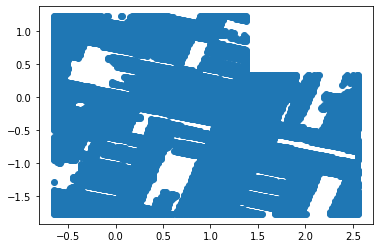

In [4]:
Y = drop_top_right(standarize(rx_positions)[:,:2], rx_positions)
plt.scatter(Y[:,0], Y[:,1])

In [5]:
X_1 = standarize(drop_top_right(data_fft, rx_positions))
X_1 = np.hstack([np.real(X_1), np.imag(X_1)])
X_2 = zero_padding_as(fillna(standarize(drop_top_right(phi, rx_positions)))[10:], X_1)
X_3 = zero_padding_as(fillna(standarize(drop_top_right(theta, rx_positions)))[10:], X_1)
X = np.hstack([X_1, X_2, X_3])

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X,Y, test_size=0.15)

In [7]:
class MyDataSet(Dataset):
    def __init__(self, X,y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
    def __len__(self):
        return self.X.shape[0]
    def channels(self):
        return self.X.shape[1]
    def timesteps(self):
        return self.X.shape[2]
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_DS = MyDataSet(train_X, train_y)
test_DS = MyDataSet(test_X, test_y)

train_loader = DataLoader(train_DS, batch_size=32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_DS, batch_size=32, drop_last=True)

In [11]:
y_real = test_DS[:][1]
#yhats = model(test_DS[:][0])

from sklearn.cluster import KMeans
km = KMeans(n_clusters=8)
km = km.fit(y_real)
labels = km.predict(y_real)

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_DS.channels(), 
                               out_channels=128, 
                               kernel_size=8,
                              stride=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        self.lin1 = nn.Linear(160, 64)
        self.lin2 = nn.Linear(64, 32)
        self.out = nn.Linear(32,latent_dim)
        
    def forward(self, x):
        x = F.normalize(F.selu(self.conv1(x)))
        x = F.normalize(F.selu(self.conv2(x)))
        x = F.normalize(F.selu(self.conv3(x)))
        x = torch.flatten(x,1)
        x = F.dropout(F.selu(self.lin1(x)), 0.2)
        x = F.dropout(F.selu(self.lin2(x)), 0.2)

        x = self.out(x)
        return x
    

In [13]:
sample = train_DS[0:1][0]
enc = Encoder()
enc(sample)

tensor([[ 0.1035,  0.1511,  0.2471,  0.2174, -0.1849,  0.2079, -0.1775,  0.0685]],
       grad_fn=<AddmmBackward>)

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(latent_dim ,32)
        self.lin2 = nn.Linear(32, 64)
        self.lin3 = nn.Linear(64, 160)
        
        self.deconv1 = nn.ConvTranspose1d(32, 64, 2, 2)
        self.deconv2 = nn.ConvTranspose1d(64, 128, 4, 2)
        self.deconv3 = nn.ConvTranspose1d(128, train_DS.channels(), 8, 2)   
        
    def forward(self, x):
        x = F.selu(self.lin1(x))
        x = F.selu(self.lin2(x))        
        x = F.selu(self.lin3(x))
        x = x.view(x.shape[0], 32, 5)
        x = F.selu(self.deconv1(x))
        x = F.selu(self.deconv2(x))        
        x = F.selu(self.deconv3(x))
        
        return x

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super(Autoencoder, self).__init__()        
        self.encoder = Encoder(latent_dim)
        #warm_start
        self.encoder.load_state_dict(torch.load("/home/evangelos/workspace/Channel_Charting/trained_models/supervised_model.pkl"), 
                                     strict=False)

        self.decoder = Decoder(latent_dim)
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        return dec, enc

In [16]:
model = Autoencoder(2)
optimizer = torch.optim.Adam(params=model.parameters())
criterion = nn.MSELoss()

In [17]:
for e in range(50):
    # train
    model.train()
    loss=0
    for x, _ in tqdm(train_loader):
        optimizer.zero_grad()
        reconstructed, mapping = model(x)
        batch_loss = criterion(x, reconstructed)
        
        batch_loss.backward()
        
        optimizer.step()
        
        loss+=batch_loss.item()
    
    #validate
    model.eval()
    val_loss = 0
    for x, _ in test_loader:
        reconstructed, _ = model(x)
        val_loss += criterion(x, reconstructed).item()
    
    print(f"Epoch {e}: Train_loss: {loss} Validation_loss: {val_loss}")


Epoch 0: Train_loss: 104.01398084266111 Validation_loss: 19.650131966453046



Epoch 1: Train_loss: 102.38138628564775 Validation_loss: 19.466146431863308



Epoch 2: Train_loss: 101.85246767755598 Validation_loss: 19.95529944449663



Epoch 3: Train_loss: 101.63457894697785 Validation_loss: 19.170197799336165



Epoch 4: Train_loss: 99.70811716467142 Validation_loss: 18.581770847551525



Epoch 5: Train_loss: 98.40148601541296 Validation_loss: 18.794462628662586



Epoch 6: Train_loss: 96.94333210634068 Validation_loss: 19.13092879531905



Epoch 7: Train_loss: 95.98490943340585 Validation_loss: 18.632396211382



Epoch 8: Train_loss: 95.57671724911779 Validation_loss: 18.56952796364203



Epoch 9: Train_loss: 94.4625147129409 Validation_loss: 19.39943717420101



Epoch 10: Train_loss: 92.95427290257066 Validation_loss: 18.956706923432648



Epoch 11: Train_loss: 92.9657591143623 Validation_loss: 18.326534275431186



Epoch 12: Train_loss: 92.32166893035173 Validation_loss: 18.320169732440263



Epoch 13: Train_loss: 92.29054994881153 Validation_loss: 18.15717704873532



Epoch 14: Train_loss: 92.53498275298625 Validation_loss: 17.94400195358321



Epoch 15: Train_loss: 92.18045880179852 Validation_loss: 17.799518197774887



Epoch 16: Train_loss: 90.19973665941507 Validation_loss: 17.44171438459307



Epoch 17: Train_loss: 91.82592983962968 Validation_loss: 17.994183354545385



Epoch 18: Train_loss: 90.27843060623854 Validation_loss: 17.498184562195092



Epoch 19: Train_loss: 89.22020445764065 Validation_loss: 17.338454101234674



Epoch 20: Train_loss: 89.32419192884117 Validation_loss: 17.38661265326664



Epoch 21: Train_loss: 90.22514763660729 Validation_loss: 18.687991275452077



Epoch 22: Train_loss: 89.89192262524739 Validation_loss: 17.530201089102775



Epoch 23: Train_loss: 90.1051235916093 Validation_loss: 17.493586437776685



Epoch 24: Train_loss: 89.6365253534168 Validation_loss: 17.070484249386936



Epoch 25: Train_loss: 88.61182938097045 Validation_loss: 17.499537953175604



Epoch 26: Train_loss: 87.78837878629565 Validation_loss: 17.144190739374608



Epoch 27: Train_loss: 89.08350188937038 Validation_loss: 17.192214793525636



Epoch 28: Train_loss: 88.14363244175911 Validation_loss: 17.912109607364982



Epoch 29: Train_loss: 87.90317046828568 Validation_loss: 17.81204584473744



Epoch 30: Train_loss: 88.61187903210521 Validation_loss: 17.212898476980627



Epoch 31: Train_loss: 87.55433856975287 Validation_loss: 17.301821489818394



Epoch 32: Train_loss: 87.43026855424978 Validation_loss: 17.46578654879704



Epoch 33: Train_loss: 87.36018798593432 Validation_loss: 17.097997410222888



Epoch 34: Train_loss: 88.60502642672509 Validation_loss: 17.887721904553473



Epoch 35: Train_loss: 88.35576030705124 Validation_loss: 16.94064743304625



Epoch 36: Train_loss: 86.6465339679271 Validation_loss: 17.388625690713525



Epoch 37: Train_loss: 86.85824668034911 Validation_loss: 17.2806434687227



Epoch 38: Train_loss: 88.38652072381228 Validation_loss: 17.569045950192958



Epoch 39: Train_loss: 86.66777793853544 Validation_loss: 17.30941187776625



Epoch 40: Train_loss: 87.2807807289064 Validation_loss: 17.232340292539448



Epoch 41: Train_loss: 87.41613532160409 Validation_loss: 17.2484140987508



Epoch 42: Train_loss: 87.38371850037947 Validation_loss: 17.757657992187887



Epoch 43: Train_loss: 85.7620554510504 Validation_loss: 17.431100466754287



Epoch 44: Train_loss: 87.33068762882613 Validation_loss: 17.915323241148144



Epoch 45: Train_loss: 85.67956562153995 Validation_loss: 17.12551903165877



Epoch 46: Train_loss: 86.7042480588425 Validation_loss: 17.19683645386249



Epoch 47: Train_loss: 87.0471535329707 Validation_loss: 17.29516541119665



Epoch 48: Train_loss: 86.9602933358401 Validation_loss: 17.55402534082532



Epoch 49: Train_loss: 86.4349938845262 Validation_loss: 17.6247530663386


In [118]:
y_real = test_DS[:][1]
yhats = model.encoder(test_DS[:][0]).detach()

In [119]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2, perplexity=30)
yhats_reduced = t_sne.fit_transform(yhats.detach())

In [120]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=8)
km = km.fit(y_real)
labels = km.predict(y_real)

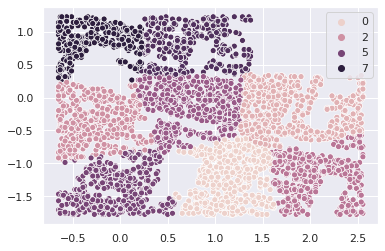

In [121]:
sns.scatterplot(y_real[:,0], y_real[:,1], hue=labels)


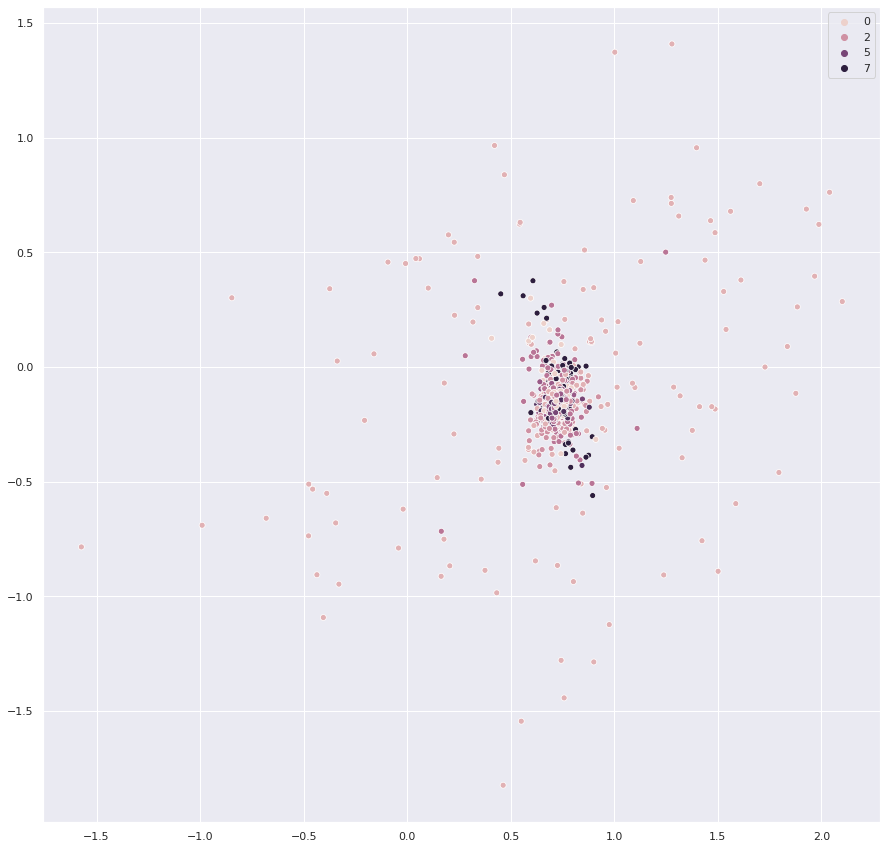

In [122]:
import seaborn as sns
sns.set()
plt.figure(figsize=(15,15))
sns.scatterplot(yhats[:,0], yhats[:,1], 
                hue=labels, 
                color='r', alpha=1) 

Visualize latent space with dbscan or t-sne and compare calculate some metrics